# 영화 평점 변화 시각화 (네이버 영화 기준)

In [1]:
from bs4 import BeautifulSoup
import urllib
from urllib.request import urlopen, urljoin, Request
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl

## Web Scraping

In [2]:
url_main = 'https://movie.naver.com/'
url_sub = 'movie/sdb/rank/rmovie.naver?sel=cur&date=20220110'

url = urlopen(url_main + url_sub)
soup = BeautifulSoup(url, 'html.parser')
soup

# 영화 제목 - Tag : div, Class : tit5
# 영화 평점 - Tag : td, Class : point


<!DOCTYPE html>

<html lang="ko">
<head>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="http://imgmovie.naver.com/today/naverme/naverme_profile.jpg" property="me2:image">
<meta content="네이버영화 " property="me2:post_tag">
<meta content="네이버영화" property="me2:category1"/>
<meta content="" property="me2:category2"/>
<meta content="랭킹 : 네이버 영화" property="og:title"/>
<meta content="영화, 영화인, 예매, 박스오피스 랭킹 정보 제공" property="og:description"/>
<meta content="article" property="og:type"/>
<meta content="https://movie.naver.com/movie/sdb/rank/rmovie.naver?sel=cur&amp;date=20220110" property="og:url"/>
<meta content="http://static.naver.net/m/movie/icons/OG_270_270.png" property="og:image"/><!-- http://static.naver.net/m/movie/im/navermovie.jpg -->
<meta content="http://imgmovie.naver.com/today/naverme/naverme_profile.jpg" property="og:article:thumbnailUrl"/>
<meta content="네이버 영화" property="og:article:author"/

In [3]:
print(soup.find_all('div', 'tit5'))

[<div class="tit5">
<a href="/movie/bi/mi/basic.naver?code=187320" title="씽2게더">씽2게더</a>
</div>, <div class="tit5">
<a href="/movie/bi/mi/basic.naver?code=201073" title="코다">코다</a>
</div>, <div class="tit5">
<a href="/movie/bi/mi/basic.naver?code=19031" title="러브레터">러브레터</a>
</div>, <div class="tit5">
<a href="/movie/bi/mi/basic.naver?code=208077" title="스파이더맨: 노 웨이 홈">스파이더맨: 노 웨이 홈</a>
</div>, <div class="tit5">
<a href="/movie/bi/mi/basic.naver?code=32588" title="아멜리에">아멜리에</a>
</div>, <div class="tit5">
<a href="/movie/bi/mi/basic.naver?code=31607" title="고양이를 부탁해">고양이를 부탁해</a>
</div>, <div class="tit5">
<a href="/movie/bi/mi/basic.naver?code=23917" title="공각기동대">공각기동대</a>
</div>, <div class="tit5">
<a href="/movie/bi/mi/basic.naver?code=205623" title="드라이브 마이 카">드라이브 마이 카</a>
</div>, <div class="tit5">
<a href="/movie/bi/mi/basic.naver?code=210282" title="엔칸토: 마법의 세계">엔칸토: 마법의 세계</a>
</div>, <div class="tit5">
<a href="/movie/bi/mi/basic.naver?code=196809" title="연애 빠진 로맨스">연애 빠진 로

In [4]:
# 영화 제목의 str 부분만 추출
soup.find_all('div', 'tit5')[0].a.string

'씽2게더'

In [5]:
# 평점 목록
soup.find_all('td', 'point')

[<td class="point">9.40</td>,
 <td class="point">9.23</td>,
 <td class="point">9.12</td>,
 <td class="point">8.92</td>,
 <td class="point">8.81</td>,
 <td class="point">8.81</td>,
 <td class="point">8.73</td>,
 <td class="point">8.72</td>,
 <td class="point">8.31</td>,
 <td class="point">8.29</td>,
 <td class="point">8.11</td>,
 <td class="point">8.00</td>,
 <td class="point">7.84</td>,
 <td class="point">7.76</td>,
 <td class="point">7.57</td>,
 <td class="point">7.09</td>,
 <td class="point">6.11</td>,
 <td class="point">5.52</td>]

In [6]:
# 영화 평점의 숫자만 추출
soup.find_all('td', 'point')[0].string

'9.40'

In [7]:
# 기간 설정 → 해당 날짜의 영화 정보 검색
date = pd.date_range('2021-7-15', periods=180, freq='D')
date

DatetimeIndex(['2021-07-15', '2021-07-16', '2021-07-17', '2021-07-18',
               '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22',
               '2021-07-23', '2021-07-24',
               ...
               '2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10'],
              dtype='datetime64[ns]', length=180, freq='D')

## 데이터 추출 및 정제

In [8]:
# 필요한 데이터 추출
movie_date = []
movie_name = []
movie_point = []

for tday in tqdm(date):
    url_day = url_main + 'movie/sdb/rank/rmovie.naver?sel=cur&date={date}'
    # {date} : soup_input 에서 date를 변수로 취급하여 내용 변경을 위한 설정
    soup_input = urlopen(url_day.format(date=urllib.parse.quote(tday.strftime('%Y%m%d'))))
    soup = BeautifulSoup(soup_input, 'html.parser')
    
    end = len(soup.find_all('td','point'))
    
    movie_date.extend([tday for n in range(0, end)])
    movie_name.extend([soup.find_all('div','tit5')[n].a.string for n in range(0, end)])
    movie_point.extend([soup.find_all('td','point')[n].string for n in range(0, end)])

  0%|          | 0/180 [00:00<?, ?it/s]

In [9]:
# DataFrame 생성
movie_df = pd.DataFrame({'Date':movie_date, 'Movie':movie_name, 'Point':movie_point})
movie_df['Point'] = movie_df['Point'].astype(float) # 실수형으로 타입 변환
movie_df.to_csv('./Naver_Movie_Ranking(210715-220110).csv', encoding='utf-8', sep=',')
movie_df.head()

,Date,Movie,Point
0,2021-07-15,극장판 귀멸의 칼날: 무한열차편,9.28
1,2021-07-15,부활: 그 증거,9.27
2,2021-07-15,크루엘라,9.25
3,2021-07-15,루카,9.06
4,2021-07-15,번지 점프를 하다,8.98


In [10]:
# 해당 기간 동안의 영화별 평점 합산 확인
import numpy as np

movie_unique = pd.pivot_table(movie_df, index=['Movie'], aggfunc=np.sum)
# pivot_table 명령과 aggfunc 옵션을 통해 영화별 평점의 합산 확인
movie_best = movie_unique.sort_values(by=['Point'], ascending=False)
# sort_values를 통해 기간 동안 평점의 합산이 가장 높은 영화 확인 가능
movie_best.head(10)

## 2021-07-15 부터 2022-01-10 까지의 평점 합산 상위 10위 영화를 확인

,Point
Movie,
너의 췌장을 먹고 싶어,1881.05
너의 이름은.,1372.37
날씨의 아이,1201.56
코다,1170.25
꽃다발 같은 사랑을 했다,1133.57
윤희에게,1111.66
노매드랜드,1049.99
블랙 위도우,941.35
모가디슈,937.02


## 특정 영화의 날짜별 평점 변화 시각화

In [11]:
movie_ch = movie_df.query('Movie == ["너의 췌장을 먹고 싶어"]') # query 사용 시 따옴표 주의 ' " " '
print(movie_ch['Point'].max(), np.round(movie_ch['Point'].mean(), 2))
movie_ch
## 해당 영화는 평점 합산 1위인 영화이지만, 최고 평점은 8.41, 평점의 평균은 8.25로 확인.
## 상영 기간이 길었기 때문에 평점 합산이 높았을 것

8.41 8.25


,Date,Movie,Point
19,2021-07-15,너의 췌장을 먹고 싶어,8.09
53,2021-07-16,너의 췌장을 먹고 싶어,8.09
87,2021-07-17,너의 췌장을 먹고 싶어,8.09
120,2021-07-18,너의 췌장을 먹고 싶어,8.09
153,2021-07-19,너의 췌장을 먹고 싶어,8.09
...,...,...,...
6565,2021-12-17,너의 췌장을 먹고 싶어,8.40
6600,2021-12-18,너의 췌장을 먹고 싶어,8.40
6633,2021-12-19,너의 췌장을 먹고 싶어,8.40
6668,2021-12-20,너의 췌장을 먹고 싶어,8.40


In [12]:
movie_ch9 = movie_df.query('Movie == ["모가디슈"]') 
print(movie_ch9['Point'].max(), np.round(movie_ch9['Point'].mean(), 2))
movie_ch9
## 평점 합산 9위로, 실제 상영 기간 동안 평점의 평균, 최고 평점은 1위 영화보다 높은 것을 확인
## 1위보다 상영 기간이 짧았기 때문에 평점 합산이 상대적으로 낮았을 것

8.73 8.29


,Date,Movie,Point
442,2021-07-28,모가디슈,8.68
479,2021-07-29,모가디슈,8.70
520,2021-07-30,모가디슈,8.73
565,2021-07-31,모가디슈,8.63
619,2021-08-01,모가디슈,8.14
...,...,...,...
6184,2021-12-06,모가디슈,8.33
6217,2021-12-07,모가디슈,8.33
6251,2021-12-08,모가디슈,8.33
6286,2021-12-09,모가디슈,8.33


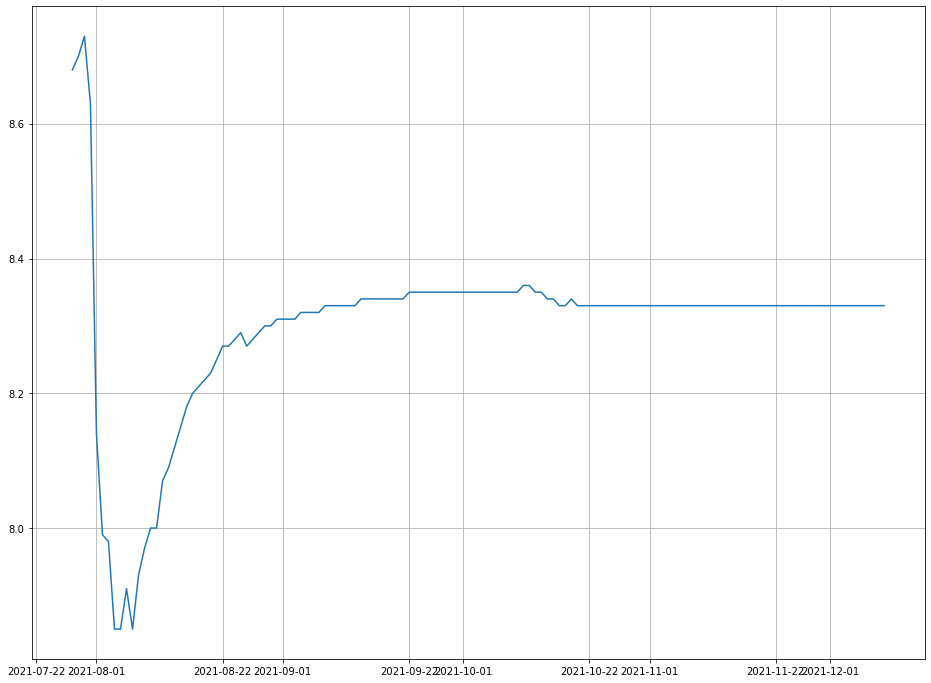

In [13]:
# 모가디슈의 날짜별 평점 변화 시각화
plt.figure(figsize = (16, 12))
plt.plot(movie_ch9['Date'], movie_ch9['Point'])
plt.grid()
plt.show()
## 8월 초 ~ 중순까지 평점이 8점 이하였지만, 8월 말부터 회복
## 9월 이후부터 상영 종료까지 평점의 평균을 상회함을 확인 가능

## 영화별 날짜 변화에 따른 평점 변화 시각화

In [14]:
movie_pivot = pd.pivot_table(movie_df, index=['Date'], columns=['Movie'], values=['Point'])
# 날짜 변화(행값) - 인덱스, 영화 이름(열값) - 컬럼, 값 - 평점
movie_pivot.head(10)

Point                                           \
Movie      007 노 타임 투 다이 120BPM 13 구역 47 미터 69세 U-571 가버나움 가을의 전설   
Date                                                                
2021-07-15           NaN    NaN   NaN   NaN NaN   NaN  NaN    NaN   
2021-07-16           NaN    NaN   NaN   NaN NaN   NaN  NaN    NaN   
2021-07-17           NaN    NaN   NaN   NaN NaN   NaN  NaN    NaN   
2021-07-18           NaN    NaN   NaN   NaN NaN   NaN  NaN    NaN   
2021-07-19           NaN    NaN   NaN   NaN NaN   NaN  NaN    NaN   
2021-07-20           NaN    NaN   NaN   NaN NaN   NaN  NaN    NaN   
2021-07-21           NaN    NaN   NaN   NaN NaN   NaN  NaN    NaN   
2021-07-22           NaN    NaN   NaN   NaN NaN   NaN  NaN    NaN   
2021-07-23           NaN    NaN   NaN   NaN NaN   NaN  NaN    NaN   
2021-07-24           NaN    NaN   NaN   NaN NaN   NaN  NaN    NaN   

                             ...                                  \
Movie      가장 따뜻한 색, 블루  강릉  ... 해피 투게더 혐오스런 마츠코의 일생 호빗 : 뜻밖의 여정   
Date                         ...                                   
2021-07-15          NaN NaN  ...    NaN          NaN         NaN   
2021-07-16          NaN NaN  ...    NaN          NaN         NaN   
2021-07-17          NaN NaN  ...    NaN          NaN         NaN   
2021-07-18          NaN NaN  ...    NaN          NaN         NaN   
2021-07-19          NaN NaN  ...    NaN          NaN         NaN   
2021-07-20          NaN NaN  ...    NaN          NaN         NaN   
2021-07-21          NaN NaN  ...    NaN          NaN         NaN   
2021-07-22          NaN NaN  ...    NaN          NaN         NaN   
2021-07-23          NaN NaN  ...    NaN          NaN         NaN   
2021-07-24          NaN NaN  ...    NaN          NaN         NaN   

                                                                            
Movie      호빗 : 스마우그의 폐허 호빗: 다섯 군대 전투 호우시절 혼자 사는 사람들 홀리 모터스  화양연화 흐르는 강물처럼  
Date                                                                        
2021-07-15           NaN          NaN  NaN       NaN    NaN  8.77      NaN  
2021-07-16           NaN          NaN  NaN       NaN    NaN  8.77      NaN  
2021-07-17           NaN          NaN  NaN       NaN    NaN  8.77      NaN  
2021-07-18           NaN          NaN  NaN       NaN    NaN  8.77      NaN  
2021-07-19           NaN          NaN  NaN       NaN    NaN  8.77      NaN  
2021-07-20           NaN          NaN  NaN       NaN    NaN  8.77      NaN  
2021-07-21           NaN          NaN  NaN       NaN    NaN  8.77      NaN  
2021-07-22           NaN          NaN  NaN       NaN    NaN  8.77      NaN  
2021-07-23           NaN          NaN  NaN       NaN    NaN  8.77      NaN  
2021-07-24           NaN          NaN  NaN       NaN    NaN  8.77      NaN  

[10 rows x 239 columns]

In [15]:
# excel 파일로 저장
movie_pivot.to_excel('./Naver Movie\'s Point(210715-220110).xlsx', encoding='utf-8')

In [16]:
# pivot_table의 컬럼명 제거 (Point 제거)
movie_pivot.columns = movie_pivot.columns.droplevel()
movie_pivot.head()

Movie,007 노 타임 투 다이,120BPM,13 구역,47 미터,69세,U-571,가버나움,가을의 전설,"가장 따뜻한 색, 블루",강릉,...,해피 투게더,혐오스런 마츠코의 일생,호빗 : 뜻밖의 여정,호빗 : 스마우그의 폐허,호빗: 다섯 군대 전투,호우시절,혼자 사는 사람들,홀리 모터스,화양연화,흐르는 강물처럼
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.77,NaN
2021-07-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.77,NaN
2021-07-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.77,NaN
2021-07-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.77,NaN
2021-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.77,NaN


In [17]:
movie_pivot.to_excel('./Naver Movie\'s Point(210715-220110).xlsx', encoding='utf-8')

In [18]:
# 한글 폰트 처리
plt.rc('font', family='Malgun Gothic')     # 윈도우, 구글 콜랩
plt.rcParams['axes.unicode_minus'] = False # 한글 폰트 처리 종료

In [19]:
# 평점의 평균 상위 10위 영화를 바탕으로 평점 시각화

mean_rank = pd.pivot_table(movie_df, index=['Movie'], aggfunc=np.mean)
# pivot_table 명령과 aggfunc 옵션을 통해 영화별 평점의 평균 확인

top_rank = mean_rank.sort_values(by=['Point'], ascending=False)
# sort_values를 통해 기간 동안 평점의 평균이 가장 높은 영화 확인

top_rank.head(10)

,Point
Movie,
밥정,9.624231
가버나움,9.590000
그린 북,9.590000
원더,9.530000
매트릭스,9.400000
씽2게더,9.400000
해리 포터와 마법사의 돌,9.349444
자산어보,9.336383
피아니스트,9.330000


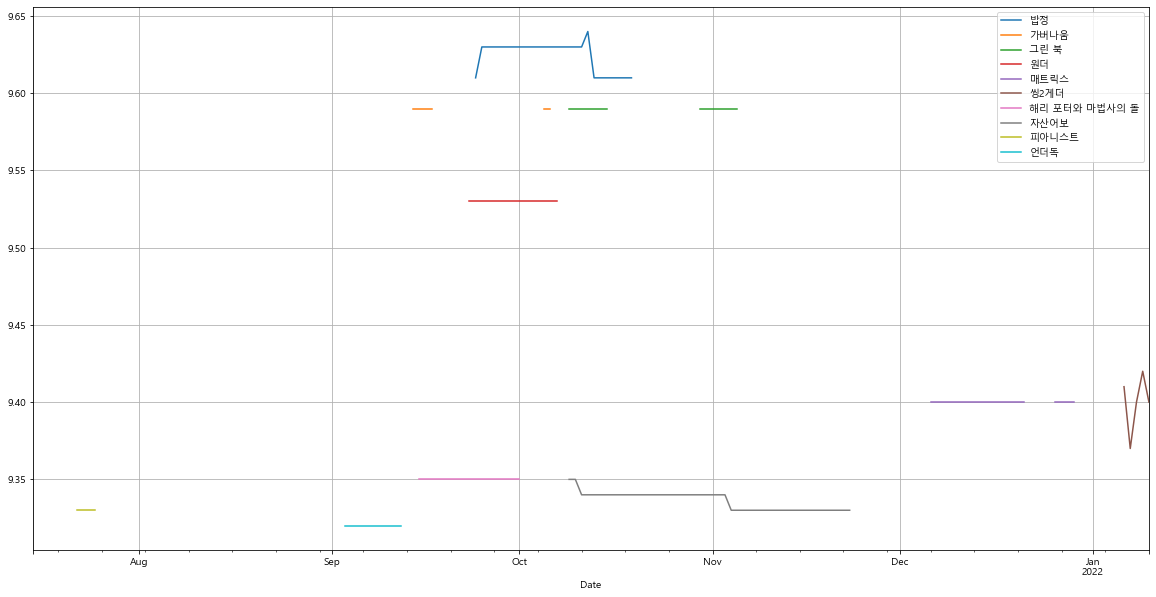

In [20]:
movie_pivot.plot(y = [top_rank.iloc[n].name for n in range(0, 10)], figsize = (20, 10))
# iloc[int].name 을 통해 Movie 명 추출 가능
plt.legend(loc='upper right')
plt.grid()
plt.show()

## 평점의 평균 순위와 흡사한 추이를 보임

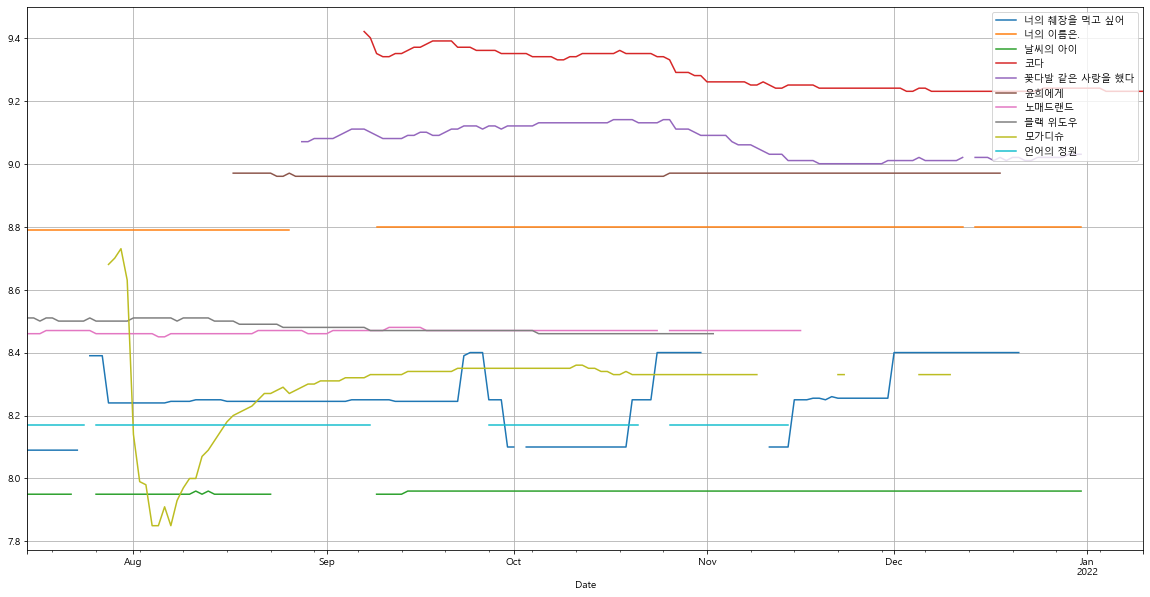

In [21]:
# 평점의 합계 기준 상위 10위 영화를 바탕으로 평점 시각화
movie_pivot.plot(y = [movie_best.iloc[n].name for n in range(0, 10)], figsize = (20, 10))
plt.legend(loc='upper right')
plt.grid()
plt.show()

## 합계와는 다르게 실제로 높은 평점을 유지한 영화는 '코다', '꽃다발 같은 사랑을 했다', '윤희에게' 등
## '너의 이름은'이나 '너의 췌장을 먹고 싶어', '날씨의 아이'는 상영 기간이 길기 때문에 평점의 총합이 높았음